In [67]:
import os
dir_path = os.getcwd()
import email
import email.policy as policy
from bs4 import BeautifulSoup
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')
from urlextract import URLExtract
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

In [2]:
def multipart_to_text(mail):
    for part in mail.get_payload():
        if part.get_content_type() in ["text/plain", "text/html"]:
            return BeautifulSoup(part.get_content()).get_text().replace("\n\n", " ")
        else:
            return False

In [3]:
def read_mails(dir_name):
    global dir_path
    emails = []
    i = 1
    for filename in os.listdir(dir_name):
        with open("{}\\{}\\{}".format(dir_path, dir_name, filename)) as f:
            try:
                mail = email.parser.Parser(policy = policy.default).parse(f)
                if "multipart" in mail.get_content_type():
                    multipart_str = multipart_to_text(mail)
                    if multipart_str:
                        emails.append(multipart_str)
                else:
                    emails.append(BeautifulSoup(mail.get_content()).get_text().replace("\n\n", " "))
            except:
                continue
            
    return emails

In [4]:
spam_mails = read_mails("Spam\\spam")
spam_2_mails = read_mails("Spam\\spam_2")
ham_mails = read_mails("Ham\\easy_ham")
ham_2_mails = read_mails("Ham\\easy_ham_2")
ham_hard_mails = read_mails("Ham\\hard_ham")

In [5]:
print(ham_hard_mails[247])


FC Sporadic  Hi,  Check out my new site,
InternalMemos.com 		Over 980 internal memos, updated daily.
		
		Recent highlights include:  
		
A&P: Salary, hiring freeze
$Exodus: Rumors, rumors, rumors
MSNBC: Sniper, parties, other news
$Ebay: San Jose office moving?
$EDS: Incentive & bonus changes
Adobe: Workforce Realignment/Reduction
$Lycos: Frank Weller resignation
AOL: Past, present, and future
TenFold: Reorganization
Ebay: Meg addresses allegations
$ Verisign: Third-party phase-out
$ Ericsson: Market unstable, moving on More internal memos...   Let me first welcome all the new people to the Sporadic -- there were a bunch of people who signed up a while ago but never got added until today, I think the problems have been fixed.  There are currently over 250,000 subscribers to this 
list (dayam!).  Of those, I think there are around 5 people who actually read it. So anyway, raise your hand if you're older than 30 and have never been married.   Unless I meet the girl of my dreams tomorro

In [6]:
print("Number of mails in spam =", len(spam_mails))
print("Number of mails in spam_2 =", len(spam_2_mails))
print("Number of mails in easy_ham =", len(ham_mails))
print("Number of mails in easy_ham_2 =", len(ham_2_mails))
print("Number of mails in hard_ham =", len(ham_hard_mails))
print()
print("Total number of spam mails =", len(spam_mails) + len(spam_2_mails))
print("Total number of ham mails =", len(ham_mails) + len(ham_2_mails) + len(ham_hard_mails))
print()
print("Percentage of spam mails =", (len(spam_mails) + len(spam_2_mails)) / (len(spam_mails) + len(spam_2_mails) + len(ham_mails) + len(ham_2_mails) + len(ham_hard_mails)))

Number of mails in spam = 483
Number of mails in spam_2 = 1337
Number of mails in easy_ham = 2499
Number of mails in easy_ham_2 = 1398
Number of mails in hard_ham = 248

Total number of spam mails = 1820
Total number of ham mails = 4145

Percentage of spam mails = 0.30511316010058676


In [7]:
def process_email(email, mail_type):
    #Replace all URLs with "urllink"
    extractor = URLExtract()
    for i in extractor.find_urls(email):
        email = email.replace(i, "urllink")
    
    #Replace special characters with spaces
    email = email.replace("e-mail", "email")
    email = re.sub("[!@#$%^&*()\[\]{};:,./<'\">?\|`~\-=_+]", " ", email)
    
    #Replace all numbers with "numberpresent"
    email = re.sub("[0-9]+", " numberpresent ", email)
    
    #Convert all characters to lowercase
    email = email.lower()
    
    #Tokenize the email, remove the stopwords, and stem the words
    stemmer = PorterStemmer()
    unprocessed_words = [w for w in word_tokenize(email) if w not in stopwords.words('english')]
    words = [stemmer.stem(w) for w in unprocessed_words]
    
    return {"unprocessed_words": unprocessed_words, "words": words, "type": mail_type * 1}

In [8]:
def create_datasets(data_list, train_percentage):
    train_set = []
    test_set = []
    for current_data in data_list:
        mail_type = current_data["type"] == "spam"
        split_size = len(current_data["data"]) * train_percentage // 100
        train_set += [process_email(mail, mail_type) for mail in (current_data["data"][0:split_size])]
        test_set += [process_email(mail, mail_type) for mail in (current_data["data"][split_size:])]
    
    unprocessed_ham_words = [mail["unprocessed_words"] for mail in train_set if mail["type"] == 0]
    unprocessed_ham_words += [mail["unprocessed_words"] for mail in test_set if mail["type"] == 0]
    unprocessed_spam_words = [mail["unprocessed_words"] for mail in train_set if mail["type"] == 1]
    unprocessed_spam_words += [mail["unprocessed_words"] for mail in test_set if mail["type"] == 1]
    
    
#     return [train_set, test_set, unprocessed_ham_words, unprocessed_spam_words]
    return [[[mail["words"] for mail in train_set], [mail["type"] for mail in train_set]], \
            [[mail["words"] for mail in test_set], [mail["type"] for mail in test_set]], \
            unprocessed_ham_words, unprocessed_spam_words]

In [9]:
train_set, test_set, unprocessed_ham_words, unprocessed_spam_words = create_datasets([{"data": spam_mails, "type": "spam"},\
                                                                                {"data": spam_2_mails, "type": "spam"},\
                                                                                {"data": ham_mails, "type": "ham"},\
                                                                                {"data": ham_2_mails, "type": "ham"},\
                                                                                {"data": ham_hard_mails, "type": "ham"}], 70)

In [73]:
print((train_set[1]))

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [11]:
unprocessed_spam_words = sum(unprocessed_spam_words, [])
unprocessed_ham_words = sum(unprocessed_ham_words, [])

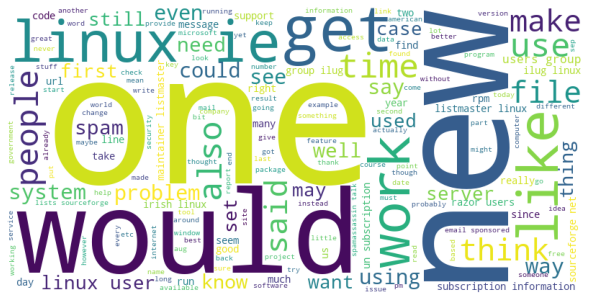

In [12]:
stopwords = ["urllink", "numberpresent", "mailing", "list"]

cloud = WordCloud(width = 800, height = 400, background_color = "white", stopwords = stopwords, min_font_size = 10)\
            .generate(" ".join(unprocessed_ham_words))

plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(cloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 

plt.show() 

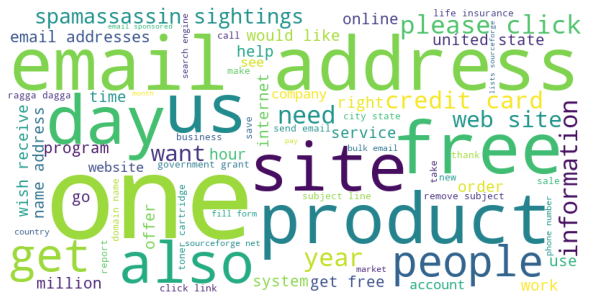

In [13]:
stopwords = ["urllink", "numberpresent", "mailing", "list"]

cloud = WordCloud(width = 800, height = 400, background_color = "white", stopwords = stopwords, min_font_size = 10)\
            .generate(" ".join(unprocessed_spam_words))

plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(cloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 

plt.show() 

In [90]:
def identity_tokenizer(mail):
    return mail

tfidf_vectorizer = TfidfVectorizer(tokenizer = identity_tokenizer, lowercase = False)
train_features = tfidf_vectorizer.fit_transform(train_set[0])
test_features = tfidf_vectorizer.transform(test_set[0])
# features = tfidf_vectorizer.fit_transform(train_set[0] + test_set[0])


In [95]:
print(np.shape(train_features))
print(np.shape(test_features))

(4173, 31244)
(1792, 31244)


In [101]:
nb_classifier = MultinomialNB()
nb_classifier.fit(train_features, train_set[1])

print("Score on the train set\t=", nb_classifier.score(train_features, train_set[1]))
print("Score on the test set\t=", nb_classifier.score(test_features, test_set[1]))

Score on the train set	= 0.9549484783129643
Score on the test set	= 0.9079241071428571
